# ANOVA 
source : https://www.reneshbedre.com/blog/anova.html

## ONE WAY ANOVA

In [1]:
## manipuler les données
import pandas

In [3]:
## données
data = pandas.read_csv("https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt", sep="\t")
data.head()

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


In [5]:
## transformer la table pour avoir un suitable for stats.model
df_melt = pandas.melt(data.reset_index(), id_vars=["index"], value_vars=data.columns)
df_melt.columns = ["index", "treatment", "value"]
df_melt

,index,treatment,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29
5,0,B,45
6,1,B,55
7,2,B,29
8,3,B,56
9,4,B,40


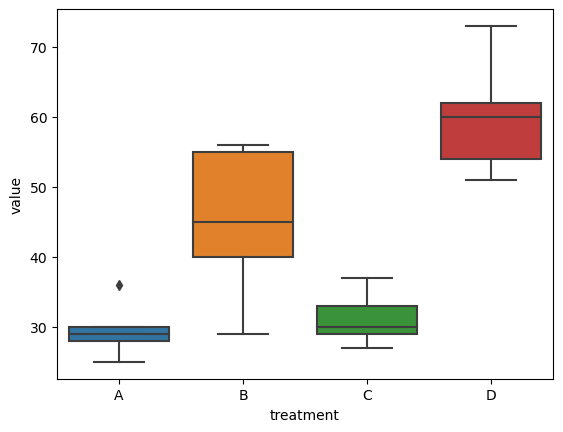

In [8]:
import seaborn
import matplotlib.pyplot as plt
## utiliser un boxplot pour identifier la distribution :
seaborn.boxplot(x="treatment", y="value", data=df_melt)
plt.show()

In [9]:
import scipy

## ANOVA one way prend les modalités de la variable catégorielle
## et retourne un résultat avec la p value :

fval, pval = scipy.stats.f_oneway(data["A"], data["B"], data["C"], data["D"])

print(fval, pval) ## une p-value très significative !

17.492810457516338 2.639241146210922e-05


la p-value est inférieure au seuil de 5%, alors on peut dire que la f-value est significativement différente du hasard.

In [15]:
## Obtenir une meilleure présentation des résultats de l'ANOVA :
import statsmodels.api
from statsmodels.formula.api import ols

## utilisation du modèle des moindres carrés ordinaires (OLS) :
model = ols("value ~ C(treatment)", data=df_melt).fit()
model ## retourne un objet de statsmodels

anova_table = statsmodels.api.stats.anova_lm(model, typ=2)
anova_table

## on pourrait utiliser bioinfokit pour obtenir un meilleur résultat visuel
## Plus la F-value sera élevée, plus la p-value sera significative.
## En gros ça fonctionne comme le pearsonr.

,sum_sq,df,F,PR(>F)
C(treatment),3010.95,3.0,17.49281,0.000026
Residual,918.00,16.0,NaN,NaN


A ce stade, on sait que les traitements (A, B, C et D) ont des effets statistiquement significatifs.
En revanche, on ne sait pas quels traitements sont statistiquement plus significatifs que d'autre.
En somme, les résultats des tests sont significatifs. Mais on n'a pas comparé nos traitements.

Pour savoir quel traitement est plus significatif qu'un autre, on opère des tests de comparaisons par pair.
On appelle ces tests des **tests post-hoc**. On utilise dans ce cas de figure le test de différenciation significative de Tukey.
**Quelles sont les conditions de validités de ce test?** ; **Est-ce que c'est un test paramétrique ? Quelle est l'alternative en non-paramétrique?** On parle du **Tukey's HSD test**.
En fait, il existe une famille de test post hoc, qui nous permettent de comparer les échantillons entre eux. Chaque technique à ses version non paramétrique d'une part. D'autre part, chaque test à ses implications statistiques (ré-ajustement de la p-value, de la valeur critique F etc).

In [17]:
import statsmodels.api
import matplotlib.pyplot as plt

from bioinfokit.analys import stat
## nous on va réaliser le test de Tukey parce que ...
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='treatment', anova_model='value ~ C(treatment)')
res.tukey_summary



C:\Users\will\Anaconda3\envs\statistics\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,15.4,1.692871,29.107129,4.546156,0.025070
1,A,C,1.6,-12.107129,15.307129,0.472328,0.900000
2,A,D,30.4,16.692871,44.107129,8.974231,0.001000
3,B,C,13.8,0.092871,27.507129,4.073828,0.048178
4,B,D,15.0,1.292871,28.707129,4.428074,0.029578
5,C,D,28.8,15.092871,42.507129,8.501903,0.001000


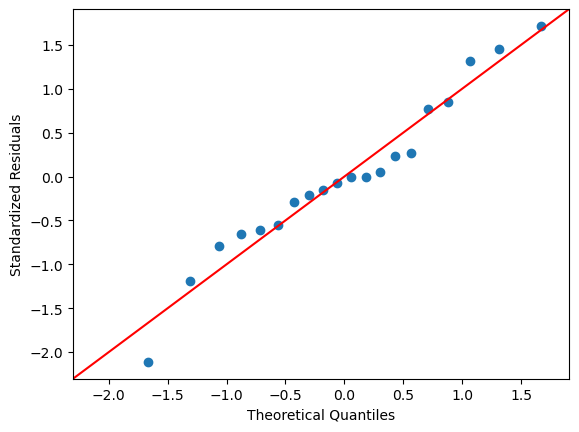

In [20]:
## ANOVA assumption
## plusieurs techniques possibles.
## pour les gros volumes de données, les méthodes de résolution graphique
##+ sont plus appropriées.
## Par exemple, le QQPLOT.

## Vérifier la normalité des résidus de l'ANOVA.
import statsmodels.api
import matplotlib.pyplot as plt

statsmodels.api.qqplot(res.anova_std_residuals, line='45') ## qqplot des résidus
plt.xlabel("Theoretical Quantiles") ## quantiles théoriques
plt.ylabel("Standardized Residuals") ## écarts-types des résidus
plt.show()

ça semble se rapprocher d'une distribution normale.
Ensuite, il faut vérifier l'homogénéité des variances.

In [21]:
import scipy.stats

w, pvalue = scipy.stats.bartlett(data["A"], data["B"], data["C"], data["D"])
print(w, pvalue)

5.687843565012841 0.1278253399753447


LA p-value est de 0.13, on peut rejeter l'hypothèse nulle et dire que les variances sont homogènes.

# Two-way ANOVA